# Introduction to the pairinteraction Library

In addition to the [graphical user interface](https://pairinteraction.github.io/images/screen-win64.png), the pairinteraction software includes a library. The library can be used to write your own code and have more fine-grained control over what pairinteraction does, e.g. for searching optimal experimental parameters or calculating effective Hamiltonians and simulating Rydberg experiments.

The library is fully written in C++ to obtain high performance. It provides a Python API generated with [SWIG](http://www.swig.org) so that one can work with all the functionality of the library in Python. The Python functions mirror the eponymous wrapped C++ functions. Thus, it is straight forward to transfer code between the two programming languages. The following introduction, which can be [downloaded](https://github.com/pairinteraction/pairinteraction/blob/master/doc/sphinx/examples_python/introduction.ipynb) as a Jupyter notebook, shows the basic usage of the pairinteraction library in Python&nbsp;3. The physics behind the presented calculations is reviewed in the pairinteraction paper [J. Phys. B: At. Mol. Opt. Phys. 50, 133001 (2017)](https://doi.org/10.1088/1361-6455/aa743a).

## Units

In the unit system used by the pairinteraction software, energies are given as frequencies in $\text{GHz}$. To obtain actual energies, the frequencies must be multiplied by Planck's constant $h$. Length has the unit $\mu\text{m}$, the magnetic field $\text{G}$, and the electric field $\text{V/cm}$.

## Preparations

### Installation
By installing a [binary build of the pairinteraction software](https://github.com/pairinteraction/pairinteraction/releases), the pairinteraction library gets installed, too. For GNU/Linux, all dependencies of the pairinteraction library are installed automatically as well, and the library can be used right away. For Windows or OS X, we recommend the installation of the Python&nbsp;3 distribution [Anaconda](https://www.anaconda.com/distribution/). Then, the dependencies can be installed by executing ``conda install numpy scipy matplotlib`` within the Anaconda terminal prompt. Its important that the installed version of the NumPy library is up-to-date.

### Importing the Library
Our code starts with loading the required modules for the calculations. We use the module `pireal` of the pairinteraction library as the calculations shown in this introduction require only real-valued matrix elements (if one considers electric or magnetic fields with a non-zero $y$-value, complex matrix elements occur due to the definition of the spherical basis and one must use `picomplex`).

In [1]:
# We call an IPython magic function to make the output of plotting commands displayed inline.
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Operating system interfaces
import os, sys

# pairinteraction :-)
# For Windows and OS X, we manually add the library path to the Python package search path.
if sys.platform == "darwin":
    sys.path.append("/Applications/pairinteraction.app/Contents/Resources")
elif sys.platform == "win32":
    sys.path.append("C:\Program Files\pairinteraction")
from libpairinteraction import pireal as pi

### Creating a Cache for Matrix Elements

The `MatrixElementCache` class provides methods for evaluating matrix elements. Each Python script using the pairinteraction library typically requires one instance of this class. The instance is then passed to every object of the pairinteraction library which needs to evaluates matrix elements. To speed up calculations, the intermediate results of the calculation of matrix elements are cached into memory. If a directory name is passed to the constructor of the class, the specified directory is used to store a SQLite database which holds the intermediate results, making them available to future program runs.

In [2]:
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

## Defining States
Rydberg states are defined in the fine structure basis by specifying the *species* and the quantum numbers $n$, $l$, $j$, $m_j$. The pairinteraction software natively supports as species the  alkali metals lithium (`"Li"`), sodium (`"Na"`), potassium (`"K"`), rubidium (`"Rb"`), caesium (`"Cs"`). In addition, there is experimental support for the alkaline earth metal strontium in its singlet (`"Sr1"`) and triplet state (`"Sr3"`). The species-specific quantum defects and model potential parameters are stored in a database, created from a [SQL file](https://github.com/pairinteraction/pairinteraction/blob/master/libpairinteraction/databases/quantum_defects.sql). Note that we do not differentiate between isotopes as they possess nearly identical quantum defects.

The user can add further species to pairinteraction by inserting their quantum defects and model potential parameters into the SQL file and creating a new database. In order to make pairinteraction use the new database, its path must be passed to the `MatrixElementCache` object by executing `cache.setDefectDB("path/to/database.db")`.

### Single Atom States
The `StateOne` class allows for defining states of single Rydberg atoms. For example, the state with the quantum numbers $n=61$, $l=0$, $j=1/2$, $m_j=-1/2$ of a rubidium atom is written as:

In [3]:
state = pi.StateOne("Rb", 61, 0, 0.5, -0.5)

### Pair States
The `StateTwo` class allows for defining states of two Rydberg atoms. Such a pair state can be defined as a combination of two single atom states.

In [4]:
state1 = pi.StateOne("Rb", 61, 0, 0.5, -0.5)
state2 = pi.StateOne("Cs", 60, 1, 1.5, 1.5)
state = pi.StateTwo(state1, state2)

Alternatively, a pair state can be initialized by specifying all parameters in pairs.

In [5]:
state = pi.StateTwo(["Rb", "Cs"], [61, 60], [0, 1], [0.5, 1.5], [-0.5, 1.5])

Afte the initialization of a pair state, the state of the first atom can be obtained by `StateTwo.getFirstState()` and the state of the second atom by `StateTwo.getSecondState()`.

The classes `StateOne` and `StateTwo` own methods for receiving the properties of the states. Species are obtained by `State[...].getSpecies()` and quantum numbers by `State[...].getN()`, `State[...].getL()`, `State[...].getJ()`, `State[...].getM()`.

## Application 1: Energy Levels

The energy of a single atom state or the total energy of a pair state is received by calling the method `State[...].getEnergy()`. Similarly, effective principal quantum numbers $n^*$ are obtained by `State[...].getNStar()`.

In [6]:
# Define Rydberg state
state = pi.StateOne("Rb", 61, 0, 0.5, 0.5)

# Get the energy of the state
print("The energy of {} is {} GHz.".format(state, state.getEnergy()))

# Get the effective principal quantum number of the state
print("The effective principal quantum number of {} is {}.".format(state, state.getNStar()))

The energy of |Rb, 61 S_1/2, mj=1/2> is -982.3898169877917 GHz.
The effective principal quantum number of |Rb, 61 S_1/2, mj=1/2> is 57.86876593760547.


## Application 2: Matrix Elements

[//]: # (TODO: discuss the units of the matrix elements, calculate LeRoy radius as an example)

The previously created instance of the `MatrixElementCache` class can be applied directly to calculate matrix elements $\langle f \rvert A_q \lvert i \rangle$, where $A_q$ is an operator in spherical coordinates, $\lvert i \rangle=\lvert n',l',j',m_j'\rangle$ is the initial Rydberg state, and $\langle f\rvert =\langle n, l, j, m \rvert$ the final Rydberg state. The order $q$ of the operator $A_q$ is assumed to equal $m_j-m_j'$. The following matrix elements are supported:

- `MatrixElementCache.getElectricDipole(state_f, state_i)` returns the matrix element of the electric dipole operator 
$d_q = \sqrt{\frac{4\pi}{3}} e r Y_{1q}$ in units of $\text{GHz}^1(\text{V}/\text{cm})^{-1}$, so that $\langle f \rvert d~E \lvert i \rangle$ and $\langle f \rvert \frac{d~d}{4\pi\epsilon_0 R^3} \lvert i \rangle$ have the unit of an energy in the [unit system](#units) used by the pairinteraction software.
- `MatrixElementCache.getElectricMultipole(state_f, state_i, kappa_radial, kappa_angular)` returns the matrix element of a generalized form of the electric multipole operator $p_{\kappa_\text{radial}, \kappa_\text{angular},q} = \sqrt{\frac{4\pi}{2\kappa_\text{angular}+1}} e r^{\kappa_\text{radial}} Y_{\kappa_\text{angular} q}$
 in units of $\text{GHz}^1(\text{V}/\text{cm})^{-1}\mu\text{m}^{\kappa_\text{radial}-1}$.
- `MatrixElementCache.getMagneticDipole(state_f, state_i)` returns the matrix element of the magnetic dipole operator $\mu_q = - \frac{\mu_B}{\hbar} (g_l l_q + g_s s_q)$ in units of $GHz^1 G^{-1}$, so that $\langle f \rvert \mu ~B \lvert i \rangle$ has the unit of an energy in the used unit system.
- `MatrixElementCache.getRadial(state_f, state_i, kappa)` returns the matrix element of the radial operator $r^\kappa$ in units of $\mu\text{m}^\kappa$. 

Note that by default, Numerov's method is used for calculating radial wave functions. If Whittaker functions should be used instead, call `MatrixElementCache.setMethod(pi.WHITTAKER)`. Take attention that for small principal quantum numbers, these methods are not accurate. In this case, we can call `MatrixElementCache.loadElectricDipoleDB("path/to/database.csv", "species")` to load [literature values](https://github.com/nikolasibalic/ARC-Alkali-Rydberg-Calculator/blob/master/arc/data) of electric dipole matrix elements that come with the [ARC software](https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/).

The calculation of matrix elements of more complex operators can often be reduced to the calculation of the matrix elements stated above. Sometimes, additional constants occure in the expressions of the operators. The library provides the following constants in the unit system of the pairinteraction software:

- `coulombs_constant` with value $1/(4\pi\epsilon_0) = 0.5955214763029308~\text{GHz}^{-1}(\text{V}/\text{cm})^2 \mu\text{m}^3$
- `electron_rest_mass` with value $m_e = 1374779.2437085041~\text{GHz}^1(\text{V}/\text{cm})^{-2}\text{G}^2$
- `elementary_charge` with value $e = 24.17989262349962~\text{GHz}^1(\text{V}/\text{cm})^{-1}\mu \text{m}^{-1}$
- `bohr_magneton` with value $\mu_B = 0.0013996245041347061~\text{GHz}^1\text{G}^{-1}$
- `reduced_planck_constant` with value $\hbar = 159.15494309517~\text{GHz}^1(\text{V}/\text{cm})^{-1}\mu \text{m}^{1}\text{G}^{1}$
- `speed_of_light` with value $c = 299.79245799420306~(\text{V}/\text{cm})^{1}\text{G}^{-1}$

As an example, we show how to calculate a matrix element of the dipole-dipole interaction operator $V_{dd} = \frac{-2d_0d_0-d_+d_- - d_-d_+}{4 \pi \epsilon_0 R^3}$.

In [7]:
# Function for calculating a matrix element of the dipole-dipole interaction operator
def getDipoleDipole(state_f, state_i, distance):
    q = state_f.getM()-state_i.getM()
    
    if q[0] == 0 and q[1] == 0:
        prefactor = -2
    elif q[0] == 1 and q[1] == -1:
        prefactor = -1
    elif q[0] == -1 and q[1] == 1:
        prefactor = -1
    else:
        return 0
    
    return prefactor * pi.coulombs_constant / distance**3 * \
        cache.getElectricDipole(state_f.getFirstState(), state_i.getFirstState()) * \
        cache.getElectricDipole(state_f.getSecondState(), state_i.getSecondState()) 

# Define Rydberg states
state_i = pi.StateTwo(["Rb", "Rb"], [61, 61], [0, 1], [0.5, 0.5], [0.5, 0.5])
state_f = pi.StateTwo(["Rb", "Rb"], [61, 61], [1, 0], [0.5, 0.5], [0.5, 0.5])

# Get the matrix element at an interatomic distance of 10 um
distance = 10 # um
matrixelement = getDipoleDipole(state_f, state_i, distance)
print("The matrix element has the value {} GHz.".format(matrixelement))

The matrix element has the value -0.0032526369083339785 GHz.


## Application 3: Dispersion Coefficients

We consider two interacting Rydberg atoms. We call the interatomic distance $R$ and the angle between the interatomic axis and the quantization axis the interaction angle $\theta$. At large interatomic distances, the energy shifts of  Rydberg pair states due to the interaction can be estimated perturbatively.

### Non-degenerate States

For the beginning, we assume that the Rydberg pair state $\lvert rr \rangle$, for which we calculate the energy shift, has no degenerate states it can couple to. Thus *second order non-degenerate perturbation theory* is applicable and the energy shift is $C_6 / R^6$, where $C_6$ is the dispersion coefficient of the van der Waals interaction. For the calculation of the $C_6$ coefficient, we only consider states that couple significantly to $\lvert rr \rangle$. We ensure this by requiring that the difference between the principal quantum numbers of $\lvert rr \rangle$ and of the considered states is less than or equal to a constant $\Delta N$, which can be set by the user to achieve convergence.

The example show how to use the method `PerturbativeInteraction.getC6(state, deltaN)` to calculate the $C_6$ coefficient in units of $\text{GHz}\,\mu\text{m}^6$, passing the state $\lvert rr \rangle$ and $\Delta N$ as arguments.

In [8]:
# Define Rydberg state for which the C6 coefficient should be calculated
state = pi.StateTwo(["Cs", "Cs"], [42, 42], [0, 0], [0.5, 0.5], [0.5, 0.5])

# Angle between the interatomic axis and the quantization axis
theta = 0 # rad

# Use only states with similar principal quantum numbers for the calculation
deltaN = 3

# Get the C6 coefficient
calculator = pi.PerturbativeInteraction(theta, cache)
print("The C6 coefficient is {} GHz um^6.".format(calculator.getC6(state, deltaN)))

The C6 coefficient is 1.2105362290320048 GHz um^6.


### Degenerate States

In case of degenerate states, we must take into account the full subspace of degenerate states and use degenerate perturbation theory. Instead of a scalar dispersion coefficient, we obtain a matrix of the dimension of the degenerate subspace. If the states within the degenerate subspace couple in second order, we are still in the van der Waals regime and must apply *second order degenerate perturbation theory*. As in the non-degenerate case, we use the method `PerturbativeInteraction.getC6(degenerate_states, deltaN)`, but now passing a list of the degenerate states as its first argument. The entries of the returned matrix are of unit $\text{GHz}\,\mu\text{m}^6$. If the states within the degenerate subspace couple directly, we are in the resonant dipole-dipole regime and must apply *first order degenerate perturbation theory*. We use the method `PerturbativeInteraction.getC3(degenerate_states)`, whose returned matrix has the unit $\text{GHz}\,\mu\text{m}^3$.

In [9]:
# Define degenerate subspace of Rydberg states that couple in second order
degenerate_states = [pi.StateTwo(["Cs", "Cs"], [42, 42], [0, 0], [0.5, 0.5], [m1, m2]) \
                     for m1 in [-0.5, 0.5] for m2 in [-0.5, 0.5]]
print("Basis of the degenerate subspace:")
print('\n'.join(str(state) for state in degenerate_states))

# Angle between the interatomic axis and the quantization axis
theta = np.pi/3 # rad

# Use only states with similar principal quantum numbers for the calculation
deltaN = 3

# Get the C6 matrix
calculator = pi.PerturbativeInteraction(theta, cache)
print("\nC6 matrix in the basis of the degenerate subspace, in GHz um^6:")
print(np.round(calculator.getC6(degenerate_states, deltaN),2))

Basis of the degenerate subspace:
|Cs, 42 S_1/2, mj=-1/2>|Cs, 42 S_1/2, mj=-1/2>
|Cs, 42 S_1/2, mj=-1/2>|Cs, 42 S_1/2, mj=1/2>
|Cs, 42 S_1/2, mj=1/2>|Cs, 42 S_1/2, mj=-1/2>
|Cs, 42 S_1/2, mj=1/2>|Cs, 42 S_1/2, mj=1/2>

C6 matrix in the basis of the degenerate subspace, in GHz um^6:
[[ 1.25  0.02  0.02 -0.04]
 [ 0.02  1.21  0.03 -0.02]
 [ 0.02  0.03  1.21 -0.02]
 [-0.04 -0.02 -0.02  1.25]]


## Application 4: Non-perturbative Calculations

In many recent Rydberg experiments, the measurements are so precise that deviations from the perturbative description are getting significant. In addition, there are Rydberg systems where perturbative calculations are not working at all because splittings between energy levels are smaller than interaction energies.  This especially happens for short interatomic distances or in the presence of electric fields. To study these systems, we must diagonalize their Hamiltonians.

We can apply the pairinteraction library to construct and diagonalize Hamiltonians of Rydberg systems. For systems consisting of one single Rydberg atom, the class `SystemOne` is provided. For two Rydberg atoms, the class `SystemTwo` is given. Both of these classes are used in a similar way:

- First, we tell which Rydberg states should be considered, letting the software create a **list of relevant Rydberg states**. The Rydberg states can be obtained by `System[...].getStates()`.
- Second, we specify whether symmetries of the systems should be taken into account to speed up calculations. The software generates a **list of basis vectors**, where each basis vector is a linear combination of the previously given Rydberg states. If symmetries are specified, they are applied to reduce the size of the basis. The basis vectors can be obtained as the columns of the NumPy `csc_matrix` returned by `System[...].getBasisvectors()`.
- Third, we set up the interactions. The software builds a **matrix representation of the Hamiltonian** in the previously generated basis. The Hamiltonian can be obtained by `System[...].getHamiltonian()` as a NumPy `csc_matrix`.

Note that some Rydberg states might rarely occur within basis vectors or some basis vectors might have neglectable norm (if we e.g. remove some states which were solely needed for getting Stark shifted energies correct). To accelerate calculations, the software removes states with overlaps $<0.05$ and basis vectors with norms $<0.05$. In order to change the threshold, call `System[...].setMinimalNorm()`. 

After calling the method `System[...].diagonalize()`, the diagonal entries of the Hamiltonian contain the eigenenergies of the system and the list of basis vectors contains the eigenvectors. For speeding up calculations, the method can be called with a threshold. Values smaller than the threshold are pruned of the eigenvectors.

### Systems of One Rydberg Atom, Calculate Stark and Zeeman Maps

The `SystemOne` class defines systems consisting of single Rydberg atoms. Optionally, an electric field can be passed to `SystemOne.setEfield(field)` as a vector containing the $x,y,z$-coordinates of the field in units of $\text{V}/\text{cm}$ (the quantization axis points along $z$). `SystemOne.setBfield(field)` allows for applying a magnetic field in units of $\text{G}$.

As an example, we show how to calculate a Stark map.

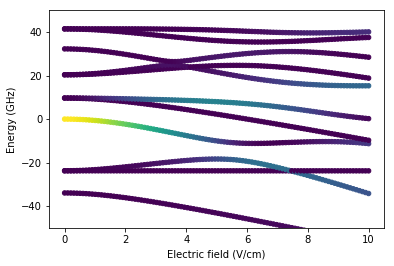

In [10]:
# Define values of E-field pointing into the direction of the quantization axis
array_efield = np.linspace(0,10,100) # V/cm

# Define state for which the Stark map should be calculated
state = pi.StateOne("Rb", 61, 1, 1.5, 1.5)

# Initialize a system comprising one rubidium Rydberg atom
system = pi.SystemOne(state.getSpecies(), cache)

# Consider only states with similar energy and quantum numbers as the defined state
system.restrictEnergy(state.getEnergy()-100, state.getEnergy()+100)
system.restrictN(state.getN()-2, state.getN()+2)
system.restrictL(state.getL()-2, state.getL()+2)

# Because E-field points along quantization axis, the magnetic quantum number is conserved
system.setConservedMomentaUnderRotation([state.getM()])

# Diagonalize the Hamiltonian of the system for different E-fields
array_eigenvalues = []
array_overlaps = []

for efield in array_efield:
    system.setEfield([0, 0, efield])
    
    # Diagonalize system, pruning values smaller than 1e-3 from eigenvectors
    system.diagonalize(1e-3)
    
    # Store the eigenenergies
    array_eigenvalues.append(system.getHamiltonian().diagonal()-state.getEnergy())
    
    # Store the overlap of the eigenstates with the defined state
    array_overlaps.append(system.getOverlap(state))

array_eigenvalues = np.ravel(array_eigenvalues)
array_overlaps = np.ravel(array_overlaps)
array_efield = np.repeat(array_efield, system.getNumBasisvectors())

# Plot Stark map, the color code visualizes overlap of eigenstates with defined state
plt.scatter(array_efield, array_eigenvalues, 20, array_overlaps)
plt.xlabel("Electric field (V/cm)")
plt.ylabel("Energy (GHz)")
plt.ylim(-50,50);

### Systems of Two Rydberg Atoms, Calculate Pair Potentials

Two instances of the class `SystemOne` can be passed to the constructor of `SystemTwo` to define a system consisting of two Rydberg atoms. The class provides methods for specifying the interaction between the Rydberg atoms. For example, the interatomic distance in $\mu\text{m}$ can be set by calling the method `SystemTwo.setDistance(distance)` and the interaction angle in $\text{rad}$ by `SystemTwo.setAngle(theta)`.

As an example, we show how to calculate pair potentials.

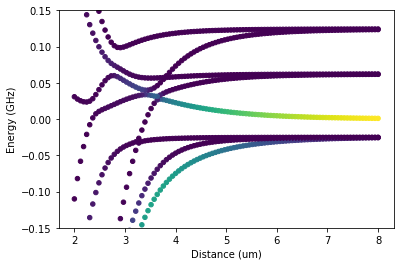

In [11]:
# Define interatomic distances
array_distance = np.linspace(8,2,100) # um

# Define interaction angle
theta = 0 # rad

""" System containing single atom """

# Define single atom state
state_one = pi.StateOne("Rb", 57, 2, 1.5, 1.5)

# Initialize a system comprising one rubidium Rydberg atom
system_one = pi.SystemOne(state_one.getSpecies(), cache)

# Consider only states with similar energy and quantum numbers as the defined state
system_one.restrictEnergy(state_one.getEnergy()-40, state_one.getEnergy()+40)
system_one.restrictN(state_one.getN()-2, state_one.getN()+2)
system_one.restrictL(state_one.getL()-2, state_one.getL()+2)

# Diagonalize one-atom system, pruning values smaller than 1e-3 from eigenvectors
system_one.diagonalize(1e-3)

""" System containing two atoms """

# Define pair state, comprising two atoms in the state defined above
state_two = pi.StateTwo(state_one, state_one)

# Initialize a new system, comprising two of the single atom systems defined above
system_two = pi.SystemTwo(system_one, system_one, cache)

# Consider only pair states with similar energy as the defined pair state
system_two.restrictEnergy(state_two.getEnergy()-4, state_two.getEnergy()+4)

# Because no electric field, parity under inversion is conserved
system_two.setConservedParityUnderInversion(pi.ODD)

# Because no multipole interaction of higher order, parity under permutation is conserved
system_two.setConservedParityUnderPermutation(pi.ODD)

# If the interaction angle is zero, the total magnetic quantum number is conserved
if (theta == 0):
    system_two.setConservedMomentaUnderRotation([int(np.sum(state_two.getM()))])

# Set interaction angle
system_two.setAngle(theta)

# Diagonalize the Hamiltonian of the system for different distances
array_eigenvalues = []
array_overlaps = []

for distance in array_distance:
    system_two.setDistance(distance)
    
    # Diagonalize two-atom system, pruning values smaller than 1e-3 from eigenvectors
    system_two.diagonalize(1e-3)
    
    # Store the eigenenergies
    array_eigenvalues.append(system_two.getHamiltonian().diagonal()-state_two.getEnergy())
    
    # Store the overlap of the eigenstates with the defined state
    array_overlaps.append(system_two.getOverlap(state_two))
    
array_eigenvalues = np.ravel(array_eigenvalues)
array_overlaps = np.ravel(array_overlaps)
array_distance = np.repeat(array_distance, system_two.getNumBasisvectors())

# Plot pair potentials, the color code visualizes overlap of eigenstates with defined state
plt.scatter(array_distance, array_eigenvalues, 20, array_overlaps)
plt.xlabel("Distance (um)")
plt.ylabel("Energy (GHz)")
plt.ylim(-0.15,0.15);

## Application 5: Effective Hamiltonians

Recent experimental progress allows for the realization of many-body systems, such as Ising-models, with Rydberg atoms. In order to obtain systems which are computationally tractable and obey vivid theoretical descriptions, one typically considers only a small subspace of atomic states and describes the interaction between them by an effective Hamiltonian.

This restriction to a small subspace $S$ is possible if the Hamiltonian can be written as $H=H_0 + H'$, where $H_0$ leaves $S$ invariant and $H'$ is a small perturbation which couples states within $S$ to states outside of $S$. We assume that this coupling is much smaller than the energy separation between states within $S$ and states outside of $S$. In this case, one often applies degenerate perturbation theory of, e.g. second order, to obtain an effective Hamiltonian. Here we use a different approach. We calculate the effective Hamiltonian by the Schrieffer-Wolff transformation ([Phys. Rev. 149, 491 (1966)](https://doi.org/10.1103/PhysRev.149.491), [Ann. Phys. 326, 2793 (2011)](https://doi.org/10.1016/j.aop.2011.06.004)). It has the benefit to work hassle-free also for complicated systems where standard perturbation theory is very hard to perform.

In the following, we focus on a relatively simple system, where we already [calculated the interaction in second order perturbation theory](#degenerate-states). The system consists of two Caesium atoms in a Rydberg s-level, separated by $4\,\mathrm{\mu m}$ with an interaction angle of $\pi/3$. Here we apply the Schrieffer-Wolff transformation to obtain the effective Hamiltonian that describes the interaction of the s-levels. We start our calculation by defining the subspace $S$ conatining the s-levels.

In [12]:
state_two_subspace = [pi.StateTwo(["Cs", "Cs"], [42,42], [0,0], [1/2, 1/2], [-1/2, -1/2]),
                      pi.StateTwo(["Cs", "Cs"], [42,42], [0,0], [1/2, 1/2], [-1/2, 1/2]),
                      pi.StateTwo(["Cs", "Cs"], [42,42], [0,0], [1/2, 1/2], [1/2, -1/2]),
                      pi.StateTwo(["Cs", "Cs"], [42,42], [0,0], [1/2, 1/2], [1/2, 1/2])]

The Hamiltonian acting on the full Hilbert space can be split into a unperturbed Hamiltonian which leaves $S$ invariant and a perturbation which couples $S$ to other states. We define a system containing the unperturbed Hamiltonian and a system containing the perturbed Hamiltonian.

In [13]:
state_one = state_two_subspace[0].getFirstState()
system_one = pi.SystemOne(state_one.getSpecies(), cache)
system_one.restrictEnergy(state_one.getEnergy()-200,state_one.getEnergy()+200)
system_one.restrictN(state_one.getN()-3, state_one.getN()+3)
system_one.restrictL(state_one.getL()-1, state_one.getL()+1)
system_two = pi.SystemTwo(system_one, system_one, cache)
system_two.restrictEnergy(state_two_subspace[0].getEnergy()-20,
    state_two_subspace[0].getEnergy()+20)

# System containing the unperturbed Hamiltonian, it's a copy of system_two
system_two_unperturbed = pi.SystemTwo(system_two)

# System containing the perturbed Hamiltonian
system_two_perturbed = pi.SystemTwo(system_two)
system_two_perturbed.setDistance(4)
system_two_perturbed.setAngle(np.pi/3)

We restrict the unperturbed system to $S$. As it does not couple the subspace to other states, this restriction can be done easily. Now the unperturbed system contains four basis vectors. The first basis vector represents the first state out of the subspace $S$, the second basis vector represents the second state, etc.

In [14]:
system_two_unperturbed.constrainBasisvectors(
    system_two_unperturbed.getBasisvectorIndex(state_two_subspace))

# Print the unperturbed Hamiltonian
print("Unperturbed Hamiltonian:\n{}\n".format(
    system_two_unperturbed.getHamiltonian().todense()))

# Print the corresponding basis vectors as columns (we just show the coefficients that 
# belong to the states contained in the considered subspace)
print("Basis vectors:\n{}".format(np.round(system_two_unperturbed.getBasisvectors()[
    list(system_two_unperturbed.getStateIndex(state_two_subspace))],3).todense()))

Unperturbed Hamiltonian:
[[-4568.44788286     0.             0.             0.        ]
 [    0.         -4568.44788286     0.             0.        ]
 [    0.             0.         -4568.44788286     0.        ]
 [    0.             0.             0.         -4568.44788286]]

Basis vectors:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


The perturbation dresses these four basis vectors by admixing other states. Using the Schrieffer-Wolff transformation, we calculate the dressed basis vectors and unitarily transform the perturbed Hamiltonian into this basis.

In [15]:
# Diagonalize the perturbed Hamiltonian, pruning values smaller than 1e-16 from 
# eigenvectors (if we prune too aggressively, the Schrieffer Wolff transformation fails)
system_two_perturbed.diagonalize(1e-16)

# Apply the Schrieffer Wolff transformation on the perturbed Hamiltonian
system_two_perturbed.applySchriefferWolffTransformation(system_two_unperturbed)

# Print the effective Hamiltonian
print("Effective Hamiltonian:\n{}\n".format(
    system_two_perturbed.getHamiltonian().todense()))

# Print the corresponding basis vectors as columns (we just show the coefficients that 
# belong to the states contained in the considered subspace)
print("Dressed basis vectors:\n{}".format(np.round(system_two_perturbed.getBasisvectors()[
    list(system_two_perturbed.getStateIndex(state_two_subspace))],5).todense()))

Effective Hamiltonian:
[[ -4.56844757e+03   5.62138780e-06   5.62138575e-06  -9.73653255e-06]
 [  5.62138780e-06  -4.56844758e+03   7.57291525e-06  -5.62138007e-06]
 [  5.62138598e-06   7.57291525e-06  -4.56844758e+03  -5.62138302e-06]
 [ -9.73653255e-06  -5.62138007e-06  -5.62138314e-06  -4.56844757e+03]]

Dressed basis vectors:
[[ 0.99997  0.       0.       0.     ]
 [ 0.       0.99997  0.       0.     ]
 [ 0.       0.       0.99997  0.     ]
 [ 0.       0.       0.       0.99997]]


As the results show, the overlap of the dressed basis vectors with the states of the subspace $S$ is still very large. Thus, we can neglect the admixture of the other states.